In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [3]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [4]:
# Read weight data
with open('../data/weight_all.pickle', 'rb') as f:
    weights = pd.DataFrame(pickle.load(f))

# Read measure units
with open('../data/unit_all.pickle', 'rb') as f:
    units = pd.DataFrame(pickle.load(f))

# Read user data (need hight for bmi computation)
with open('../data/filtered/users_filter.pickle', 'rb') as f:
    users = pd.DataFrame(pickle.load(f))



In [5]:
#Decode measure units

# select str columns
str_df = units.select_dtypes([np.object])
# convert them all
str_df = str_df.stack().str.decode('utf-8').unstack()
# swap converted with original columns
for col in str_df:
    units[col] = str_df[col]
    
units = units.drop_duplicates()

# Data overview

## Users Data (filtered)

In [6]:
users.head()

,birthday,height,sex,user_id,birthyear
0,1964-11-08 01:00:00,163.0,female,00003941-eab1-4c08-8e57-96612cb7094d,1964
1,1967-08-05 01:00:00,187.0,male,0000767c-089c-415f-a3ea-10a83eff7115,1967
2,2000-05-27 02:00:00,172.0,male,0000f27e-7b4e-4cb0-875d-6d067e078291,2000
3,1998-01-15 01:00:00,160.0,female,0000f645-78c3-4c1e-b170-56a0fe33f39a,1998
4,1954-03-06 00:00:00,163.0,female,00011407-dce4-4332-ab28-dc0a13969fab,1954


In [7]:
printmd('**Total number of users:** {}'.format(len(users)))

**Total number of users:** 253313

## Weight data

In [8]:
weights.head()

,bmi,body_fat,body_weight,muscle_mass,updated_date,user_id
0,28.9685,26.6,101.3,33.2,2017-03-26 14:59:31,0000767c-089c-415f-a3ea-10a83eff7115
1,29.0257,26.6,101.5,33.2,2017-03-26 14:59:53,0000767c-089c-415f-a3ea-10a83eff7115
2,20.1122,10.5,59.5,51.8,2017-03-02 19:29:13,0000f27e-7b4e-4cb0-875d-6d067e078291
3,20.1798,10.5,59.7,51.8,2017-03-02 19:29:13,0000f27e-7b4e-4cb0-875d-6d067e078291
4,20.3488,10.3,60.2,52.0,2017-03-02 19:29:13,0000f27e-7b4e-4cb0-875d-6d067e078291


In [9]:
printmd('**Number of weight entries:** {}'.format(len(weights)))
printmd('**Number of users with at least one weight entry:** {}'.format(
    len(weights['user_id'].unique())))

**Number of weight entries:** 3092900

**Number of users with at least one weight entry:** 97693

## Unit measures

In [10]:
units.head()

,measure_unit,user_id
0,kilos,720d79be-b7b5-47bf-94c2-f78544a44475
1,kilos,bff303ce-f2c8-4bba-9caf-45a41d0c710c
2,kilos,c9606d51-e9b7-4810-82f2-a325d32f4cad
3,kilos,8fd79cf9-668d-4da1-950d-96b20bc4ff97
4,kilos,204d30ed-eb85-42e4-992b-3eb6e723dcc1


In [11]:
printmd('**Number of unit measure entries:** {}'.format(len(units)))
printmd('**Number of users with at least one unit measure registered:** {}'.format(
    len(units['user_id'].unique())))

**Number of unit measure entries:** 128955

**Number of users with at least one unit measure registered:** 128946

## Filter user unit metrics

In [12]:
# Count measures other than kilos
not_unit_kilos = units.groupby('user_id')['measure_unit'].agg(lambda x: any(x != 'kilos'))
not_unit_kilos = not_unit_kilos[not_unit_kilos==True]
printmd('**Unit metrics found: **{}'.format(
    units['measure_unit'].loc[units.user_id.isin(not_unit_kilos.index)].unique()))
printmd('**Number of users with metrics different from \'kilos\': **{}'.format(
    len(units[units.user_id.isin(not_unit_kilos.index)])))

# Remove metrics other than kilos
printmd('**Remove user with metrics different from \'kilos\'**')

len_before = len(units)
units = units[-units.user_id.isin(not_unit_kilos.index)]
printmd('* Number of entries removed: {}'.format(len_before - len(units)))
printmd('* Number of remaining entries: {}'.format(len(units)))

printmd('**Are there null values in the units table?** {}'.format(
    units.isnull().values.any()))


**Unit metrics found: **['pounds' 'kilos' 'stones']

**Number of users with metrics different from 'kilos': **123

**Remove user with metrics different from 'kilos'**

* Number of entries removed: 123

* Number of remaining entries: 128832

**Are there null values in the units table?** False

## Filter user weights

In [40]:
# Filter weight entries in kilos
printmd('**Remove weight entries not in kilos**')
len_before = len(weights)
weights_filter = weights[weights.user_id.isin(units['user_id'])]
printmd('* Number of weight entries removed: {}'.format(len_before - len(weights_filter)))
printmd('* Number of remaining weight entries: {}'.format(len(weights_filter)))

**Remove weight entries not in kilos**

* Number of weight entries removed: 44598

* Number of remaining weight entries: 3048302

In [41]:
# Filter columns and count entries with null values 
printmd('**Keep only columns of interest: ** [user_id, updated_date, body_weight, bmi]')
# weights_filter = weights_filter[['user_id', 'updated_date', 'body_weight', 'bmi']]
printmd('* Number of body_weight null values: {}'.format(
    weights_filter['body_weight'].isnull().values.sum()))
printmd('* Number of updated_date null values: {}'.format(
    weights_filter['updated_date'].isnull().values.sum()))
printmd('* Number of bmi null values: {}'.format(
    weights_filter['bmi'].isnull().values.sum()))

**Keep only columns of interest: ** [user_id, updated_date, body_weight, bmi]

* Number of body_weight null values: 0

* Number of updated_date null values: 0

* Number of bmi null values: 5993

### Statistical profile of weight data

**Original Data:**

* _Max Weight:_ 1000.0

* _Min Weight:_ 0.0

* _Mean Weight:_ 83.96830606868139

* _Standard Deviation:_ 38.095848237797014 

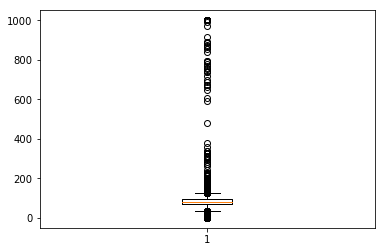

**Remove weight outliers**

* Number of outliers removed: 95039

* Number of remaining weights entried: 2953263

**Filtered Data:**

* _Max Weight:_ 127.647

* _Min Weight:_ 36.853

* _Mean Weight:_ 82.31156580463532

* _Standard Deviation:_ 16.015538419492994 

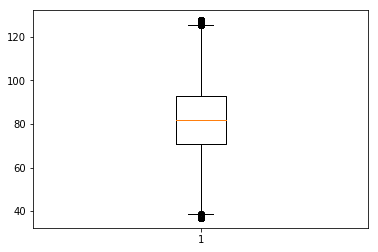

In [42]:
printmd('**Original Data:**')
printmd('* _Max Weight:_ {}'.format(weights_filter['body_weight'].max()))
printmd('* _Min Weight:_ {}'.format(weights_filter['body_weight'].min()))
printmd('* _Mean Weight:_ {}'.format(weights_filter['body_weight'].mean()))
printmd('* _Standard Deviation:_ {} '.format(weights_filter['body_weight'].std()))

box = plt.boxplot(weights_filter['body_weight'], 0)
plt.show()

outliers = box["fliers"][0].get_data()[1]

printmd('**Remove weight outliers**')
len_before = len(weights_filter)
weights_filter = weights_filter[-weights_filter.body_weight.isin(outliers)]
printmd('* Number of outliers removed: {}'.format(len_before - len(weights_filter)))
printmd('* Number of remaining weights entried: {}'.format(len(weights_filter)))

printmd('**Filtered Data:**')
printmd('* _Max Weight:_ {}'.format(weights_filter['body_weight'].max()))
printmd('* _Min Weight:_ {}'.format(weights_filter['body_weight'].min()))
printmd('* _Mean Weight:_ {}'.format(weights_filter['body_weight'].mean()))
printmd('* _Standard Deviation:_ {} '.format(weights_filter['body_weight'].std()))

box = plt.boxplot(weights_filter['body_weight'], 0)
plt.show()


### Handle multiple wieght entries for same user and same timestamp

In [43]:
# Compute standard deviation of multiple wieght entries for same user and same timestamp
measure_date_std = weights_filter.groupby(
        ['user_id', 'updated_date'])['body_weight'].transform('std')
measure_date_std = measure_date_std.dropna()

**Visualize variation of multiple measures**

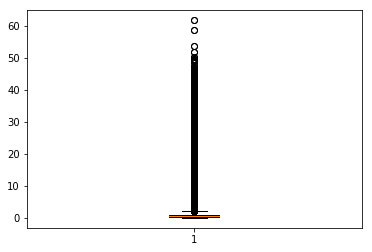

**Sample noisy data**

,bmi,body_fat,body_weight,muscle_mass,updated_date,user_id
176,29.5062,30.6,95.6,25.0,2016-09-17 08:46:20,00070076-fbb3-4f7a-9b11-d067693acc04
177,29.5062,30.7,95.6,25.0,2016-09-17 08:46:20,00070076-fbb3-4f7a-9b11-d067693acc04
241,29.7840,31.0,96.5,25.0,2017-02-25 12:23:29,00070076-fbb3-4f7a-9b11-d067693acc04
242,29.7840,31.1,96.5,25.0,2017-02-25 12:23:29,00070076-fbb3-4f7a-9b11-d067693acc04
301,29.5955,35.6,79.6,29.0,2016-01-03 22:55:22,0008848a-d4c4-473f-bf73-9ac35bc2fc4e


**Sample non-noisy data**

,bmi,body_fat,body_weight,muscle_mass,updated_date,user_id
2,20.1122,10.5,59.5,51.8,2017-03-02 19:29:13,0000f27e-7b4e-4cb0-875d-6d067e078291
3,20.1798,10.5,59.7,51.8,2017-03-02 19:29:13,0000f27e-7b4e-4cb0-875d-6d067e078291
4,20.3488,10.3,60.2,52.0,2017-03-02 19:29:13,0000f27e-7b4e-4cb0-875d-6d067e078291
5,20.3488,10.7,60.2,51.7,2017-03-02 19:29:13,0000f27e-7b4e-4cb0-875d-6d067e078291
10,20.3150,10.5,60.1,51.9,2017-03-22 17:39:15,0000f27e-7b4e-4cb0-875d-6d067e078291


**Remove noisy multiple measures**

* Number of noisy measures removed: 152030

**Visualize variation of multiple measures after noise filtering**

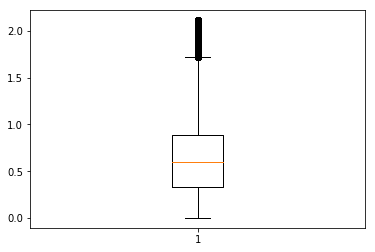

**Maximum standard deviation admited in multiple measures:** 2.1156634893101534

In [44]:
printmd('**Visualize variation of multiple measures**')
box = plt.boxplot(list(measure_date_std), 0)
plt.show()

printmd('**Sample noisy data**')
di.display(weights_filter.loc[
    measure_date_std[measure_date_std.isin(outliers)].index].head())

printmd('**Sample non-noisy data**')
di.display(weights_filter.loc[
    measure_date_std[-measure_date_std.isin(outliers)].index].head())

printmd('**Remove noisy multiple measures**')
len_before = len(weights_filter)
outliers = box["fliers"][0].get_data()[1]
weights_filter = weights_filter.drop(
    measure_date_std[measure_date_std.isin(outliers)].index)

printmd('* Number of noisy measures removed: {}'.format(
    len_before - len(weights_filter)))

printmd('**Visualize variation of multiple measures after noise filtering**')
measure_date_std = weights_filter.groupby(
        ['user_id', 'updated_date'])['body_weight'].transform('std')
measure_date_std = measure_date_std.dropna()
box = plt.boxplot(list(measure_date_std), 0)
plt.show()

printmd('**Maximum standard deviation admited in multiple measures:** {}'.format(
    max(list(measure_date_std))))


In [35]:
printmd('***take the average of multiple measures***')
weights_filter['body_weight'] = weights_filter.groupby(
        ['user_id', 'updated_date'])['body_weight'].transform('mean')
printmd('* Number of duplicated entries after averagind multiple measures: {}'.format(
 weights_filter.duplicated().sum()))

***take the average of multiple measures***

* Number of duplicated entries after averagind multiple measures: 90915

In [196]:
# Recompute bmi (this will also fill nulls)

# Keep only entries where user data is available
weights_filter = weights_filter[
    weights_filter.user_id.isin(users.user_id)]

print(weights_filter.duplicated().sum())
# Get height for users tables
weights_filter = weights_filter.merge(users[['user_id', 'height']], on='user_id')
print(weights_filter.duplicated().sum())

# Compute bmi
weights_filter['bmi'] = weights_filter['body_weight']/pow(
    (weights_filter['height']/100),2)

# Check there are no null values for bmi
print(weights_filter['bmi'].isnull().values.sum())

# Drop duplicates (introduced when taking mean value per user, timestamp)
weights_filter = weights_filter.drop_duplicates()

328101
328101
0


In [198]:
weights_filter.duplicated().sum()

0

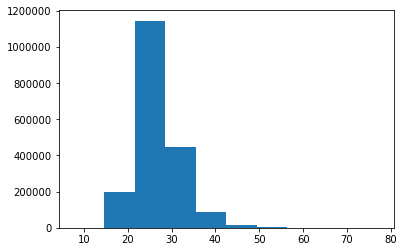

In [199]:
# Bmi Histogram
n, bins, patches = plt.hist(
    list(weights_filter['bmi'].values), bins = 10)
plt.show()

In [200]:
print(weights_filter['bmi'].quantile(0.9999))
print(weights_filter['bmi'].quantile(0.0002))
weights_filter = weights_filter[
    (weights_filter.bmi > 13) &
    (weights_filter.bmi < 60)
]

58.10856816326172
11.370505267011097


In [201]:
weights_filter.duplicated().sum()

0

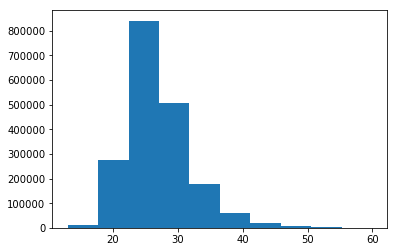

In [202]:
# Bmi Histogram
n, bins, patches = plt.hist(
    list(weights_filter['bmi'].values), bins = 10)
plt.show()

In [ ]:
# Weight Histogram
n, bins, patches = plt.hist(
    list(weights_filter['body_weight'].values), bins = 10)
plt.show()

In [204]:
with open('weights_filter.pickle', 'wb') as f:
    pickle.dump(weights_filter, f)